In [1]:
! pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 575 kB 27.8 MB/s 


In [2]:
import numpy as np
import pandas as pd

from matplotlib.colors import rgb2hex
from matplotlib.cm import get_cmap
import matplotlib.pyplot as plt

from collections import defaultdict, Counter

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report
from sklearn import metrics

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import RidgeClassifier, SGDClassifier, Lasso, RidgeCV
from xgboost import XGBClassifier

import shap

import altair as alt
import random
from tqdm import tqdm

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data pre-processing and visualization

In [4]:
def parseFile( file_name ):
	f = open(file_name)
	featureArray = []
	lines = f.readlines()
	for line in lines:
		feature_length = len(line.split(" "))

		raw_feature = line.split(" ")

		feature = []

		for index in range(feature_length):
			try:
				feature.append( float( raw_feature[index] ))
			except:
				continue
		
		featureArray.append( feature )

	return np.asarray( featureArray )

In [5]:
folder = 'drive/MyDrive/human-activity-data-toronto-ucu/UCI-HAR-Dataset/'

#Parsing Full training dataset
XFull = parseFile(folder + 'train/X_train.txt')
YFull = parseFile(folder + 'train/y_train.txt')

#Parsing Full testing dataset
XFullTest = parseFile(folder + 'test/X_test.txt')
YFullTest = parseFile(folder + 'test/y_test.txt')

In [6]:
XFull

array([[ 0.28858451, -0.02029417, -0.13290514, ..., -0.84124676,
         0.17994061, -0.05862692],
       [ 0.27841883, -0.01641057, -0.12352019, ..., -0.8447876 ,
         0.18028889, -0.05431672],
       [ 0.27965306, -0.01946716, -0.11346169, ..., -0.84893347,
         0.18063731, -0.04911782],
       ...,
       [ 0.27338737, -0.01701062, -0.04502183, ..., -0.77913261,
         0.24914484,  0.04081119],
       [ 0.28965416, -0.01884304, -0.15828059, ..., -0.78518142,
         0.24643223,  0.02533948],
       [ 0.35150347, -0.01242312, -0.20386717, ..., -0.78326693,
         0.24680852,  0.03669484]])

In [7]:
len(XFull), len(XFull[1])

(7352, 561)

In [8]:
len(XFullTest)

2947

### Features & labels names

In [9]:
f = open(folder + 'features.txt')
featureArray = []
features = []
lines = f.readlines()

for line in lines:
  raw_feature = line.split(" ")
  features.append(raw_feature[1][:-1])

In [10]:
f = open(folder + 'activity_labels.txt')
featureArray = []
activity_labels = []
lines = f.readlines()

for line in lines:
  raw_feature = line.split(" ")
  activity_labels.append(raw_feature[1][:-1])

activity_labels

['WALKING',
 'WALKING_UPSTAIRS',
 'WALKING_DOWNSTAIRS',
 'SITTING',
 'STANDING',
 'LAYING']

### Activity Exploration

In [11]:
train_df = pd.DataFrame(XFull, columns=features)
train_df['label'] = YFull
train_df['activity'] = [activity_labels[int(x)-1] for x in train_df['label']]
train_df

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",label,activity
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,5.0,STANDING
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,5.0,STANDING
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,5.0,STANDING
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663,5.0,STANDING
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892,5.0,STANDING
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7347,0.299665,-0.057193,-0.181233,-0.195387,0.039905,0.077078,-0.282301,0.043616,0.060410,0.210795,...,-0.880324,-0.190437,0.829718,0.206972,-0.425619,-0.791883,0.238604,0.049819,2.0,WALKING_UPSTAIRS
7348,0.273853,-0.007749,-0.147468,-0.235309,0.004816,0.059280,-0.322552,-0.029456,0.080585,0.117440,...,-0.680744,0.064907,0.875679,-0.879033,0.400219,-0.771840,0.252676,0.050053,2.0,WALKING_UPSTAIRS
7349,0.273387,-0.017011,-0.045022,-0.218218,-0.103822,0.274533,-0.304515,-0.098913,0.332584,0.043999,...,-0.304029,0.052806,-0.266724,0.864404,0.701169,-0.779133,0.249145,0.040811,2.0,WALKING_UPSTAIRS
7350,0.289654,-0.018843,-0.158281,-0.219139,-0.111412,0.268893,-0.310487,-0.068200,0.319473,0.101702,...,-0.344314,-0.101360,0.700740,0.936674,-0.589479,-0.785181,0.246432,0.025339,2.0,WALKING_UPSTAIRS


In [12]:
# Group and count main names of columns
pd.DataFrame.from_dict(Counter([col.split('-')[0].split('(')[0] for col in train_df.columns]), orient='index').rename(columns={0:'count'}).sort_values('count', ascending=False)

,count
fBodyAcc,79
fBodyGyro,79
fBodyAccJerk,79
tGravityAcc,40
tBodyAcc,40
tBodyGyroJerk,40
tBodyGyro,40
tBodyAccJerk,40
tBodyAccMag,13
tGravityAccMag,13


From the plot below we can see that the classes are highly separable which will definitely help out model to distingusih classes with high accuracy.

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.


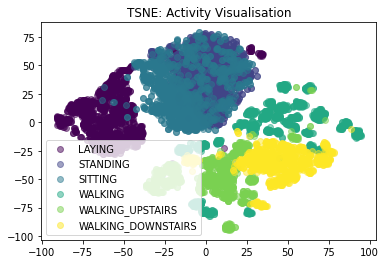

In [13]:
# Create datasets
tsne_data = train_df.copy()
subject_data = tsne_data.pop('activity')

# Scale data
scl = StandardScaler()
tsne_data = scl.fit_transform(tsne_data)

# Reduce dimensions (speed up)
pca = PCA(n_components=0.9, random_state=3)
tsne_data = pca.fit_transform(tsne_data)

# Transform data
tsne = TSNE(random_state=3)
tsne_transformed = tsne.fit_transform(tsne_data)


# Create subplots
plt.plot(figsize=(15,10))

### Plot Activities
# Get colors
n = len(activity_labels)
colormap = get_cmap('viridis')
colors = [rgb2hex(colormap(col)) for col in np.arange(0, 1.01, 1/(n-1))]

# Plot each activity
label_counts = subject_data.value_counts()
for i, group in enumerate(label_counts.index):
    # Mask to separate sets
    mask = (subject_data==group).values
    plt.scatter(x=tsne_transformed[mask][:,0], y=tsne_transformed[mask][:,1], c=colors[i], alpha=0.5, label=group)
plt.title('TSNE: Activity Visualisation')
plt.legend()

plt.show()

## Human activity classification

Compared different classifiers performance on this problem.

In [ ]:
names = [
    "Lasso",
    "Ridge",
    "XGBoost",
    "Stochastic Gradient Descent",
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "Decision Tree",
    "Random Forest",
    "AdaBoost",
    "Naive Bayes",
    "QDA",
]

classifiers = [
    Lasso(alpha=0.1),
    RidgeClassifier(),
    XGBClassifier(),
    SGDClassifier(),
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
]

### Evaluation

As metrics, we considered accuracy and F1 score.

In [ ]:
for name, clf in zip(names, classifiers):
    clf.fit(XFull, YFull.flatten())
    score = clf.score(XFullTest, YFullTest)

    y_pred = clf.predict(XFullTest)
    predictions = [round(value) for value in y_pred]
    # evaluate predictions
    accuracy = metrics.accuracy_score(YFullTest, predictions)
    f1_score = metrics.f1_score(YFullTest, predictions, average="weighted")
    
    print(name)
    print("Accuracy: %.2f%%" % (accuracy * 100.0))
    print("F1 score: %.2f%%" % (f1_score * 100.0))
    print("Built-in score: %.2f%%" % (score * 100.0))
    print()

Lasso
Accuracy: 41.74%
F1 score: 36.41%
Built-in score: 83.01%

Ridge
Accuracy: 95.69%
F1 score: 95.71%
Built-in score: 95.69%

XGBoost
Accuracy: 93.96%
F1 score: 93.94%
Built-in score: 93.96%

Stochastic Gradient Descent
Accuracy: 94.23%
F1 score: 94.19%
Built-in score: 94.23%

Nearest Neighbors
Accuracy: 89.07%
F1 score: 88.99%
Built-in score: 89.07%

Linear SVM
Accuracy: 95.52%
F1 score: 95.51%
Built-in score: 95.52%

RBF SVM
Accuracy: 18.22%
F1 score: 5.62%
Built-in score: 18.22%

Decision Tree
Accuracy: 83.85%
F1 score: 83.66%
Built-in score: 83.85%

Random Forest
Accuracy: 73.40%
F1 score: 72.12%
Built-in score: 73.40%

AdaBoost
Accuracy: 53.10%
F1 score: 39.44%
Built-in score: 53.10%

Naive Bayes
Accuracy: 77.03%
F1 score: 76.88%
Built-in score: 77.03%



Variables are collinear


QDA
Accuracy: 80.08%
F1 score: 79.44%
Built-in score: 80.08%



## Explanation for models with the best performance

Models considered for explanation:
- Ridge Classifier
- XGBoost
- Stochastic Gradient Descent
- Linear SVM

### Grouping similar features

In [ ]:
groups = ["tBodyAcc-XYZ",
          "tGravityAcc-XYZ",
          "tBodyAccJerk-XYZ",
          "tBodyGyro-XYZ",
          "tBodyGyroJerk-XYZ",
          "tBodyAccMag",
          "tGravityAccMag",
          "tBodyAccJerkMag",
          "tBodyGyroMag",
          "tBodyGyroJerkMag",
          "fBodyAcc-XYZ",
          "fBodyAccJerk-XYZ",
          "fBodyGyro-XYZ",
          "fBodyAccMag",
          "fBodyAccJerkMag",
          "fBodyGyroMag",
          "fBodyGyroJerkMag"]

### Shapley values

XGBoost

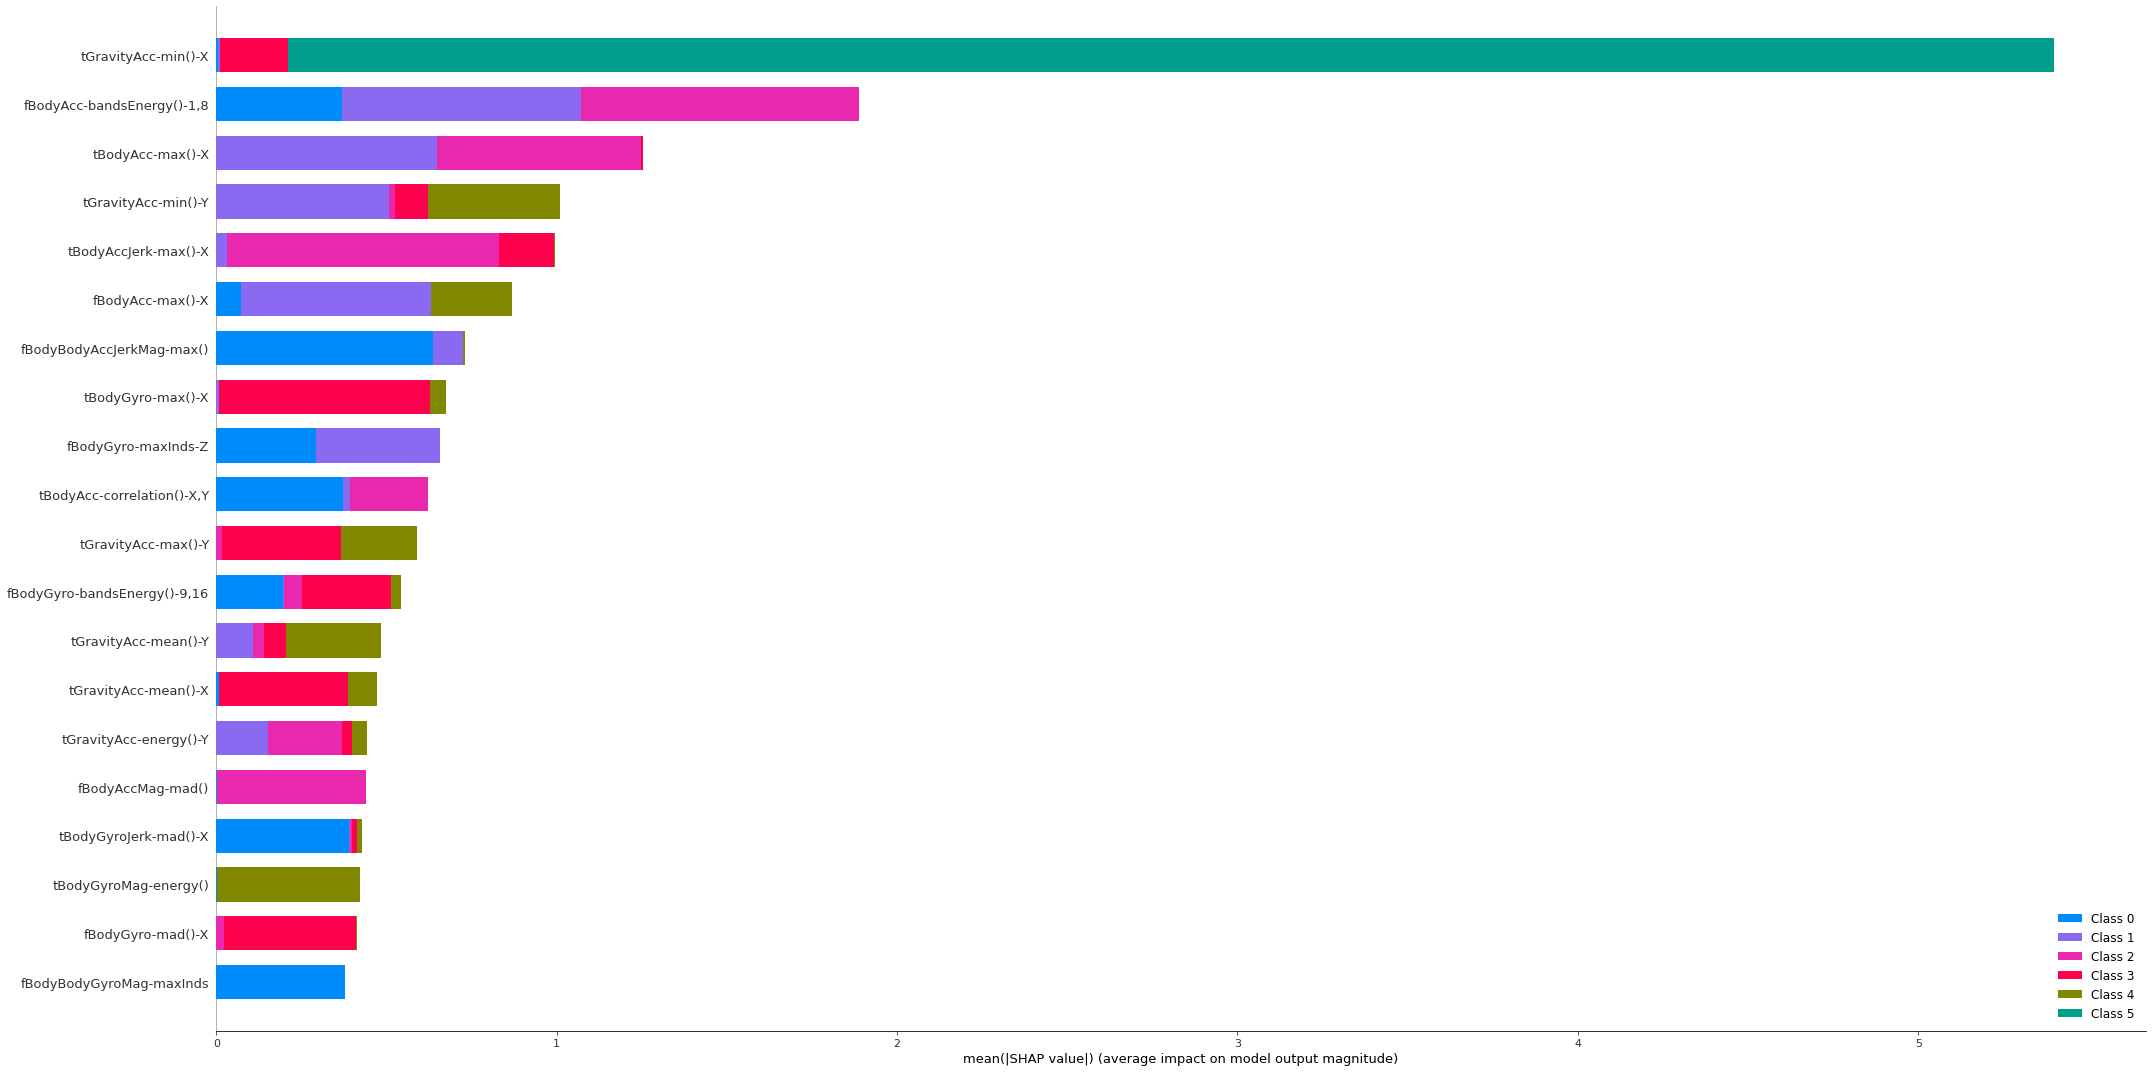

In [14]:
model = XGBClassifier()
model.fit(XFull, YFull.flatten())

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(XFull)
shap.summary_plot(shap_values, #Use Shap values array
              features=XFull, # Use training set features
              feature_names=features, #Use column names
              show=False, #Set to false to output to folder
              plot_size=(30,15)) # Change plot size

In [19]:
vals= np.abs(shap_values).mean(0)

feature_importance = pd.DataFrame(list(zip(features, sum(vals))), columns=['feature','feature_importance_val'])
feature_importance.sort_values(by=['feature_importance_val'], ascending=False,inplace=True)

xgboost_shapley_features_sorted = list(feature_importance["feature"])

In [21]:
xgboost_shapley_features_sorted

['tGravityAcc-min()-X',
 'fBodyAcc-bandsEnergy()-1,8',
 'tBodyAcc-max()-X',
 'tGravityAcc-min()-Y',
 'tBodyAccJerk-max()-X',
 'fBodyAcc-max()-X',
 'fBodyBodyAccJerkMag-max()',
 'tBodyGyro-max()-X',
 'fBodyGyro-maxInds-Z',
 'tBodyAcc-correlation()-X,Y',
 'tGravityAcc-max()-Y',
 'fBodyGyro-bandsEnergy()-9,16',
 'tGravityAcc-mean()-Y',
 'tGravityAcc-mean()-X',
 'tGravityAcc-energy()-Y',
 'fBodyAccMag-mad()',
 'tBodyGyroJerk-mad()-X',
 'tBodyGyroMag-energy()',
 'fBodyGyro-mad()-X',
 'fBodyBodyGyroMag-maxInds',
 'tBodyGyroJerk-iqr()-X',
 'fBodyAcc-bandsEnergy()-1,8',
 'tBodyGyroJerk-min()-X',
 'tBodyGyro-energy()-Z',
 'tBodyGyro-iqr()-X',
 'tBodyAcc-entropy()-X',
 'angle(Y,gravityMean)',
 'fBodyGyro-maxInds-X',
 'tBodyAccJerk-max()-Z',
 'fBodyAccJerk-bandsEnergy()-1,8',
 'tBodyGyro-min()-X',
 'fBodyAccJerk-maxInds-X',
 'tBodyGyro-correlation()-Y,Z',
 'tGravityAcc-min()-Z',
 'tBodyGyroJerk-max()-Z',
 'fBodyAccMag-std()',
 'tBodyAccJerk-max()-Y',
 'fBodyGyro-meanFreq()-X',
 'tBodyGyro-iqr()-Y

### Feature importance using model coefficients

In [ ]:
top = 15

Ridge Classifier

Top features:
- gravity
- tBodyGyroJerk
- tBodyAccJerkMag

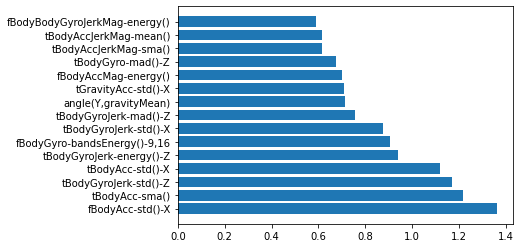

In [ ]:
clf = RidgeClassifier()
clf.fit(XFull, YFull.flatten())

imp = abs(clf.coef_[0])
imp, names = zip(*sorted(list(zip(imp, features))))

plt.barh(range(top), imp[::-1][0:top], align='center')
plt.yticks(range(top), names[::-1][0:top])
plt.show()

ridge_features_sorted = names[::-1]

XGBoost

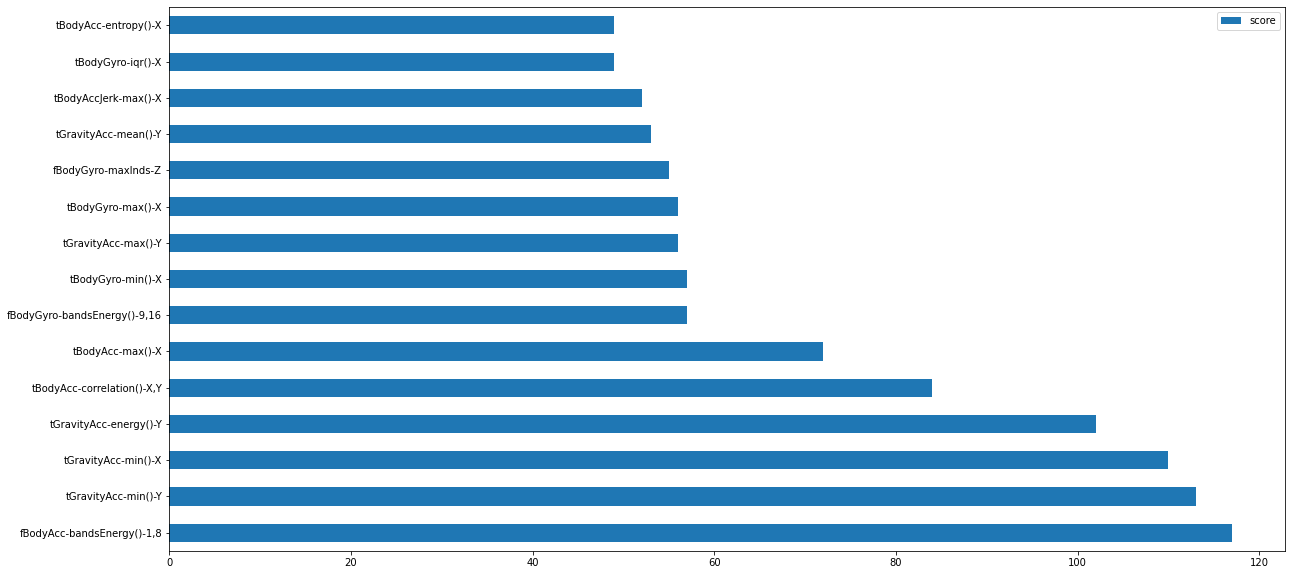

In [ ]:
model = XGBClassifier()
model.fit(XFull, YFull.flatten())

feature_important = model.get_booster().get_score(importance_type='weight')

xgboost_names_to_features = model.get_booster().feature_names
keys = [features[xgboost_names_to_features.index(name)] for name in feature_important.keys()]
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(top, columns="score").plot(kind='barh', figsize = (20,10)) ## plot top 15 features

In [ ]:
xgboost_coeffs_features_sorted = data.index.values.tolist()

Stochastic Gradient Descent Classifier

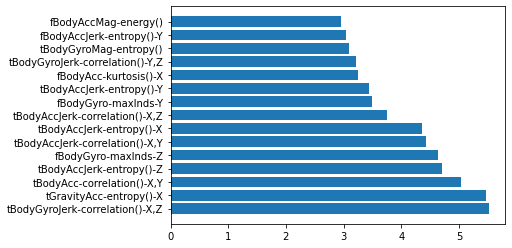

In [ ]:
clf = SGDClassifier()
clf.fit(XFull, YFull.flatten())

imp = abs(clf.coef_[0])
imp, names = zip(*sorted(list(zip(imp, features))))

plt.barh(range(top), imp[::-1][0:top], align='center')
plt.yticks(range(top), names[::-1][0:top])
plt.show()

sgd_features_sorted = names[::-1]

Linear SVM

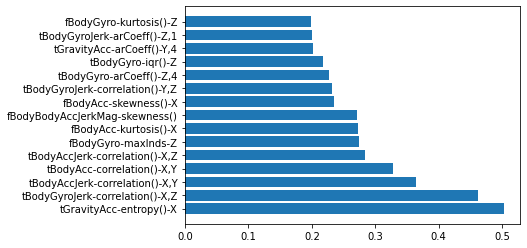

In [ ]:
svm = SVC(kernel="linear", C=0.025)
svm.fit(XFull, YFull.flatten())

imp = abs(svm.coef_[0])
imp, names = zip(*sorted(list(zip(imp, features))))

top = 15
plt.barh(range(top), imp[::-1][0:top], align='center')
plt.yticks(range(top), names[::-1][0:top])
plt.show()

svm_features_sorted = names[::-1]

### Validation of the explanation approaches

Experiment with droping most important features

In [15]:
def visualize_results(df, title):
    accuracy_line = alt.Chart(df).mark_line(color="red").encode(
        x = alt.X('features_drop_numb', title="Number of features dropped"), 
        y = alt.Y('accuracy', title="Best features metrics")
    )
    # f1_line = alt.Chart(df).mark_line(color="blue").encode(
    #     x = alt.X('features_drop_numb', title="Number of features dropped"),
    #     y = alt.Y('f1_score', title="Best features metrics")
    # )

    rand_accuracy_line = alt.Chart(df).mark_line(color="blue").encode(
        x = alt.X('features_drop_numb', title="Number of features dropped"), 
        y = alt.Y('rand_accuracy', title="Random features metrics")
    )
    # rand_f1_line = alt.Chart(df).mark_line(color="blue").encode(
    #     x = alt.X('features_drop_numb', title="Number of features dropped"),
    #     y = alt.Y('rand_f1_score', title="Random features metrics")
    # )

    combined = accuracy_line + rand_accuracy_line

    combined = combined.properties(
      title=alt.TitleParams(
          text=title,
          fontSize=22,
      )
    )
    return combined

In [16]:
def calculate_metrics(clf, features_list, title):
    accuracy_list = []
    f1_list = []
    rand_accuracy_list = []
    rand_f1_list = []

    # removing most important features
    for f_numb in tqdm(range(1, len(features_list))):
        indxs = [features.index(f) for f in features_list[:f_numb]]
        XFull_exp = np.delete(XFull, indxs, axis=1)
        XFullTest_exp = np.delete(XFullTest, indxs, axis=1)

        clf.fit(XFull_exp, YFull.flatten())

        y_pred = clf.predict(XFullTest_exp)
        predictions = [round(value) for value in y_pred]
        # evaluate predictions
        accuracy = metrics.accuracy_score(YFullTest, predictions)
        f1_score = metrics.f1_score(YFullTest, predictions, average="weighted")

        accuracy_list.append(accuracy)
        f1_list.append(f1_score)

    # removing random features
    for f_numb in tqdm(range(1, len(features_list))):
        indxs = random.sample(range(1, len(features_list)), f_numb)
        XFull_exp = np.delete(XFull, indxs, axis=1)
        XFullTest_exp = np.delete(XFullTest, indxs, axis=1)

        clf.fit(XFull_exp, YFull.flatten())

        y_pred = clf.predict(XFullTest_exp)
        predictions = [round(value) for value in y_pred]
        # evaluate predictions
        accuracy = metrics.accuracy_score(YFullTest, predictions)
        f1_score = metrics.f1_score(YFullTest, predictions, average="weighted")

        rand_accuracy_list.append(accuracy)
        rand_f1_list.append(f1_score)


    df = pd.DataFrame()
    df["features_drop_numb"] = list(range(1, len(features_list)))
    df["accuracy"] = accuracy_list
    df["f1_score"] = f1_list
    df["rand_accuracy"] = rand_accuracy_list
    df["rand_f1_score"] = rand_f1_list

    return visualize_results(df, title)

In [17]:
def calculate_metrics_xgboost(clf, features_list, title):
    accuracy_list = []
    f1_list = []
    rand_accuracy_list = []
    rand_f1_list = []

    # removing most important features
    for f_numb in tqdm(range(1, len(features_list), 10)):
        indxs = [features.index(f) for f in features_list[:f_numb]]
        XFull_exp = np.delete(XFull, indxs, axis=1)
        XFullTest_exp = np.delete(XFullTest, indxs, axis=1)

        clf.fit(XFull_exp, YFull.flatten())

        y_pred = clf.predict(XFullTest_exp)
        predictions = [round(value) for value in y_pred]
        # evaluate predictions
        accuracy = metrics.accuracy_score(YFullTest, predictions)
        f1_score = metrics.f1_score(YFullTest, predictions, average="weighted")

        accuracy_list.append(accuracy)
        f1_list.append(f1_score)

    # removing random features
    for f_numb in tqdm(range(1, len(features_list), 10)):
        indxs = random.sample(range(1, len(features_list)), f_numb)
        XFull_exp = np.delete(XFull, indxs, axis=1)
        XFullTest_exp = np.delete(XFullTest, indxs, axis=1)

        clf.fit(XFull_exp, YFull.flatten())

        y_pred = clf.predict(XFullTest_exp)
        predictions = [round(value) for value in y_pred]
        # evaluate predictions
        accuracy = metrics.accuracy_score(YFullTest, predictions)
        f1_score = metrics.f1_score(YFullTest, predictions, average="weighted")

        rand_accuracy_list.append(accuracy)
        rand_f1_list.append(f1_score)


    df = pd.DataFrame()
    df["features_drop_numb"] = list(range(1, len(features_list), 10))
    df["accuracy"] = accuracy_list
    df["f1_score"] = f1_list
    df["rand_accuracy"] = rand_accuracy_list
    df["rand_f1_score"] = rand_f1_list

    return visualize_results(df, title)

**Ridge Classifier**

Base metrics

*   Accuracy: 95.69%
*   F1 score: 95.71%

In [ ]:
calculate_metrics(RidgeClassifier(), ridge_features_sorted, "Ridge Classifier")

100%|██████████| 560/560 [01:42<00:00,  5.46it/s]


alt.LayerChart(...)

**XGBoost**

Base metrics

*   Accuracy: 93.96%
*   F1 score: 93.94%

In [ ]:
calculate_metrics_xgboost(XGBClassifier(), xgboost_coeffs_features_sorted, "XGBoost for Coeffs features")

100%|██████████| 34/34 [55:29<00:00, 97.93s/it]


alt.LayerChart(...)

In [20]:
calculate_metrics_xgboost(XGBClassifier(), xgboost_shapley_features_sorted, "XGBoost for Shapley features")

100%|██████████| 56/56 [44:30<00:00, 47.68s/it]


alt.LayerChart(...)

**Stochastic Gradient Descent Classifier**

Base metrics

*   Accuracy: 94.23%
*   F1 score: 94.19%

In [ ]:
calculate_metrics(SGDClassifier(), sgd_features_sorted, "SGD Classifier")

100%|██████████| 560/560 [09:38<00:00,  1.03s/it]


alt.LayerChart(...)

**Linear SVM**

Base metrics

*   Accuracy: 95.52%
*   F1 score: 95.51%

In [ ]:
calculate_metrics(SVC(kernel="linear", C=0.025), svm_features_sorted, "Linear SVM")

100%|██████████| 560/560 [17:11<00:00,  1.84s/it]


alt.LayerChart(...)